In [ ]:
import chardet
from datetime import timedelta, datetime
import functools
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import time
from tqdm import tqdm
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functools import lru_cache
import geopandas
from geopy.geocoders import Nominatim
from scipy.interpolate import interp1d
from shapely.geometry import Point
from pandas._libs.tslibs.offsets import YearEnd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dict_stations = {
'mizpe_ramon': [69, 379, 265, 296],
'avdat': [271, 335],
'sede_boker': [98],
'arad': [29, 240],
'beer_sheva': [59, 293, 60, 411, 412]
}
new_list = []
for k, v in dict_stations.items():
    for i in v:
        url = f"https://api.ims.gov.il/v1/envista/stations/{i}"
        headers = {'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'}
        response = requests.get(url, headers=headers)
        data = json.loads(response.text.encode('utf8'))
        new_list.append((k, data['name'], data['location']))
for i in new_list:
    print(i)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/10min_data/arad_station_10min_rain_01092000_01062001.csv")
def one_df_10min_to_monthly(df):
  df[['rain_amount', 'temperature','humidity']] = df[['rain_amount', 'temperature','humidity']].clip(lower=0)
  #df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce').fillna(0)

  df['start_rain'] = pd.to_datetime(df['start_rain'], format='%d/%m/%Y %H:%M')

  # Create new columns for 'month', 'year', and 'day' from 'start_rain' column
  df['month'] = df['start_rain'].dt.month
  df['year'] = df['start_rain'].dt.year

  # Group the DataFrame by 'year' and 'month', then aggregate the data
  aggregated_df = df.groupby(['year', 'month']).agg({
      'rain_amount': 'sum',
      'temperature': 'mean',
      'humidity': 'mean'
  }).reset_index()

  # Optionally, you can format the 'year' and 'month' columns as desired
  aggregated_df['year'] = aggregated_df['year'].astype(str)
  aggregated_df['month'] = aggregated_df['month'].apply(lambda x: '{:02d}'.format(x))

  # Combine 'year' and 'month' into a new 'month_year' column if needed
  aggregated_df['month_year'] = aggregated_df['year'] + '-' + aggregated_df['month']

  # Drop 'year' and 'month' columns if 'month_year' is used
  aggregated_df.drop(['year', 'month'], axis=1, inplace=True)

  return aggregated_df

In [ ]:
def aggregate_data(df, group_by):
    grouped = df.groupby(group_by).agg({
        'rain_amount': 'sum',
        'temperature': 'mean',
        'humidity': 'mean'
    }).reset_index()

    return grouped

In [ ]:
def many_df_10min_to_monthly(name_station, group_by='month'):
  df_monthly = pd.DataFrame()
  for year in tqdm(range(2000, 2022)):
    try:
      df_i = pd.read_csv(f"/content/drive/MyDrive/data/10min_data/{name_station}_station_10min_rain_0109{year}_0106{year+1}.csv")

      if 'faran' == name_station:
        df_i.rename(columns={
        'תחנה': 'rain_station',
        'תאריך ושעה (שעון קיץ)': 'start_rain',
        'לחות יחסית (%)': 'humidity',
        'טמפרטורה (C°)': 'temperature',
        'כמות גשם (מ"מ)': 'rain_amount'
        }, inplace=True)

      df_i = one_df_10min_to_monthly(df_i)
      df_monthly = pd.concat([df_monthly, df_i])
    except:
      pass
  df_monthly['month'] = pd.to_datetime(df_monthly['month_year'], format ='%Y-%m').dt.month
  df_monthly['year'] = pd.to_datetime(df_monthly['month_year'], format ='%Y-%m').dt.year
  df_monthly = df_monthly.drop_duplicates(subset='month_year')
  return aggregate_data(df_monthly, 'month')


In [ ]:
df_arad = many_df_10min_to_monthly('arad')
df_beer_sheva = many_df_10min_to_monthly('beer_sheva')
df_avdat = many_df_10min_to_monthly('avdat')
df_faran = many_df_10min_to_monthly('faran')
df_mizpe_ramon = many_df_10min_to_monthly('mizpe_ramon')
df_sede_boker = many_df_10min_to_monthly('sede_boker')

100%|██████████| 22/22 [00:04<00:00,  5.29it/s]


In [ ]:
#df_beer_sheva['rain_amount'] = df_beer_sheva['rain_amount'].apply(lambda x: 100 if x > 5000 else x)
# df_arad['humidity'], df_arad['temperature'] = df_arad['temperature'], df_arad['humidity']
# df_beer_sheva['humidity'], df_beer_sheva['temperature'] = df_beer_sheva['temperature'], df_beer_sheva['humidity']


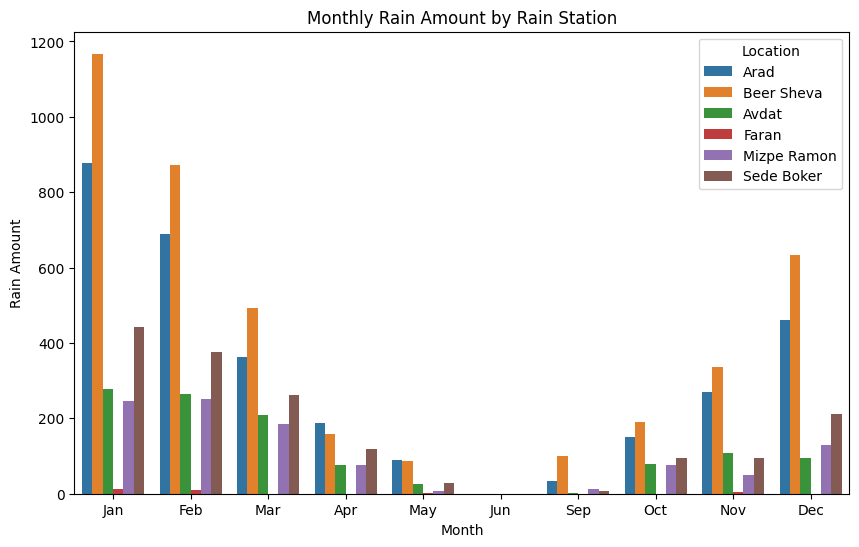

In [ ]:
# Add a 'Location' column to each dataframe
df_arad['Location'] = 'Arad'
df_beer_sheva['Location'] = 'Beer Sheva'
df_avdat['Location'] = 'Avdat'
df_faran['Location'] = 'Faran'
df_mizpe_ramon['Location'] = 'Mizpe Ramon'
df_sede_boker['Location'] = 'Sede Boker'

# Concatenate all dataframes into one
all_data = pd.concat([df_arad, df_beer_sheva, df_avdat, df_faran, df_mizpe_ramon, df_sede_boker])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x='month', y='rain_amount', hue='Location')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Rain Amount')
plt.title('Monthly Rain Amount by Rain Station')

# Set x-axis ticks to show all months (assuming 12 months)
plt.xticks(range(0,10), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Location')

# Show the plot
plt.show()


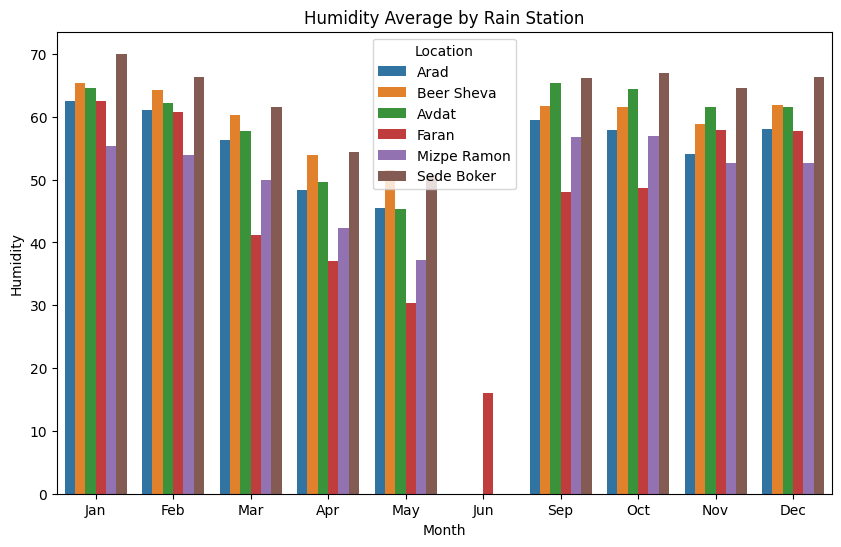

In [ ]:
# Add a 'Location' column to each dataframe
df_arad['Location'] = 'Arad'
df_beer_sheva['Location'] = 'Beer Sheva'
df_avdat['Location'] = 'Avdat'
df_faran['Location'] = 'Faran'
df_mizpe_ramon['Location'] = 'Mizpe Ramon'
df_sede_boker['Location'] = 'Sede Boker'

# Concatenate all dataframes into one
all_data = pd.concat([df_arad, df_beer_sheva, df_avdat, df_faran, df_mizpe_ramon, df_sede_boker])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x='month', y='humidity', hue='Location')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Humidity')
plt.title('Humidity Average by Rain Station')

# Set x-axis ticks to show all months (assuming 12 months)
plt.xticks(range(0,10), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Location')

# Show the plot
plt.show()


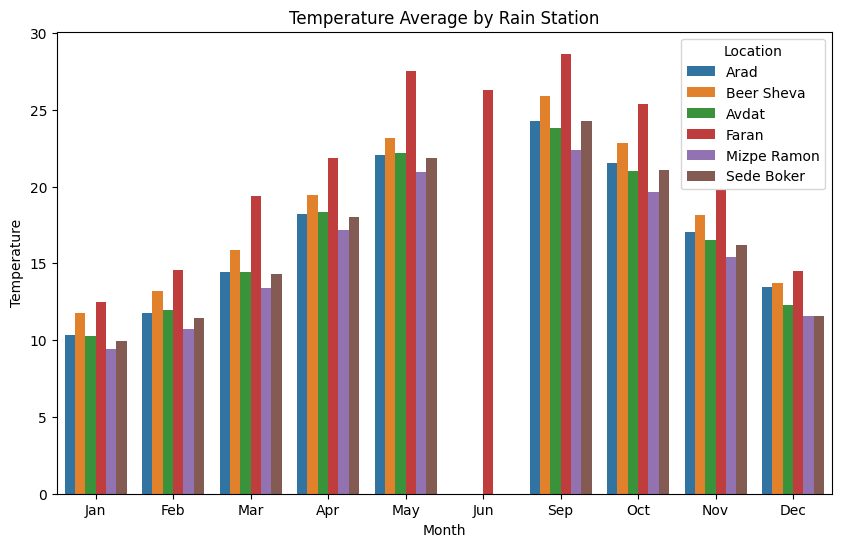

In [ ]:
# Add a 'Location' column to each dataframe
df_arad['Location'] = 'Arad'
df_beer_sheva['Location'] = 'Beer Sheva'
df_avdat['Location'] = 'Avdat'
df_faran['Location'] = 'Faran'
df_mizpe_ramon['Location'] = 'Mizpe Ramon'
df_sede_boker['Location'] = 'Sede Boker'

# Concatenate all dataframes into one
all_data = pd.concat([df_arad, df_beer_sheva, df_avdat, df_faran, df_mizpe_ramon, df_sede_boker])

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=all_data, x='month', y='temperature', hue='Location')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature Average by Rain Station')

# Set x-axis ticks to show all months (assuming 12 months)
plt.xticks(range(0,10), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
plt.legend(title='Location')

# Show the plot
plt.show()


In [ ]:
def func_flow_in_river(file_csv, river_name):
  def detect_encoding(file_path):
      with open(file_path, 'rb') as f:
          result = chardet.detect(f.read())
      return result['encoding']
  flow_in_river_encoding = detect_encoding(file_csv)
  flow_in_river = pd.read_csv(file_csv, encoding=flow_in_river_encoding)
  flow_in_river = flow_in_river[['שם תחנה', 'שם תחנה באנגלית',  'זמן מדידת ספיקה',  '''ספיקה (מ''ק/שנייה)''']]
  flow_in_river.rename(columns={
      'שם תחנה': 'river_name_hebrew',
      'שם תחנה באנגלית': 'river_name_english',
      'זמן מדידת ספיקה': 'flow_time',
      '''ספיקה (מ''ק/שנייה)''': 'flow_amount'
  }, inplace=True)
  flow_in_river = flow_in_river[flow_in_river['river_name_hebrew'] == river_name]
  flow_in_river = flow_in_river[['river_name_hebrew', 'river_name_english', 'flow_time', 'flow_amount']]
  return flow_in_river

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/link_of_rain_station_to_river_preprocess.csv")
unique_values = data['נחל'].unique()
print(len(unique_values))
list_of_years = [(2000,2010),(2010,2019),(2019,2021)]

24


In [ ]:
flows = pd.DataFrame()
for tup in list_of_years:
  (y1,y2) = tup
  curr = pd.DataFrame()
  for river_name in tqdm(unique_values):
    dfi = func_flow_in_river(f"/content/drive/MyDrive/data/flow_in_river_{y1}_to_{y2}_hebrew.csv",river_name)
    curr = pd.concat([curr,dfi])
  flows = pd.concat([flows,curr])
flows.sort_values(by='river_name_english')

  8%|▊         | 2/24 [00:06<01:14,  3.39s/it]<ipython-input-85-b72008e6435f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_in_river.rename(columns={
 17%|█▋        | 4/24 [00:11<00:55,  2.78s/it]<ipython-input-85-b72008e6435f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_in_river.rename(columns={
 29%|██▉       | 7/24 [00:20<00:52,  3.09s/it]<ipython-input-85-b72008e6435f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,river_name_hebrew,river_name_english,flow_time,flow_amount
964006,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,21/02/2015 22:06,38.740
222726,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 18:50,0.594
222727,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 19:00,0.594
222728,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 19:40,0.396
222729,הערבה-עין יהב,ARAVA - EN YAHAV RESERVOIR,16/12/2020 19:59,0.132
...,...,...,...,...
218141,צאלים,NaN,18/02/2021 12:05,0.300
218142,צאלים,NaN,18/02/2021 15:40,0.090
218143,צאלים,NaN,18/02/2021 19:28,0.030
218144,צאלים,NaN,19/02/2021 4:25,0.000


In [ ]:
flows

,river_name_hebrew,river_name_english,flow_time,flow_amount
796487,ציחור,ZIHOR,09/12/2000 11:29,0.000
796488,ציחור,ZIHOR,09/12/2000 11:30,0.003
796489,ציחור,ZIHOR,09/12/2000 11:35,0.004
796490,ציחור,ZIHOR,09/12/2000 11:36,0.007
796491,ציחור,ZIHOR,09/12/2000 11:43,0.703
...,...,...,...,...
170071,גרר - רעים,GERAR - RE'IM,04/03/2021 16:45,1.466
170072,גרר - רעים,GERAR - RE'IM,04/03/2021 17:40,1.466
170073,גרר - רעים,GERAR - RE'IM,04/03/2021 17:45,1.354
170074,גרר - רעים,GERAR - RE'IM,04/03/2021 19:03,0.000


In [ ]:
flows.to_csv("/content/drive/MyDrive/data/flows_concatenated.csv",index = False, encoding = "")

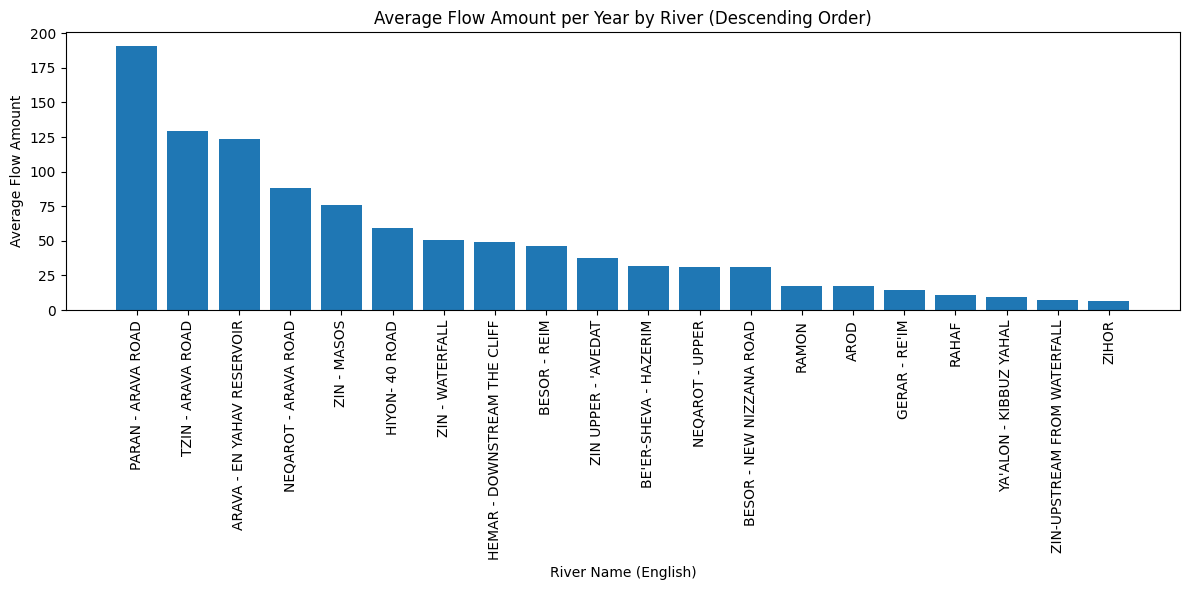

In [ ]:
flows['flow_time'] = pd.to_datetime(flows['flow_time'], format='%d/%m/%Y %H:%M')
flows['year'] = flows['flow_time'].dt.year
river_avg_flow = flows.groupby(['river_name_english', 'year'])['flow_amount'].mean().reset_index()
river_avg_flow_sorted = river_avg_flow.sort_values(by='flow_amount', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(river_avg_flow_sorted['river_name_english'], river_avg_flow_sorted['flow_amount'])
plt.xlabel('River Name (English)')
plt.ylabel('Average Flow Amount')
plt.title('Average Flow Amount per Year by River (Descending Order)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
def plot_rivers_with_flow_by_month(df, year):
    # Step 1: Delete the 'flow_amount' column
    df = df.drop('flow_amount', axis=1)

    # Step 2: Create 'year' and 'month' features
    df['flow_time'] = pd.to_datetime(df['flow_time'], format='%d/%m/%Y %H:%M')
    df['year'] = df['flow_time'].dt.year
    df['month'] = df['flow_time'].dt.month

    # Step 3: Filter data for the specified year
    year_data = df[(df['year'] == year)]

    # Step 4: Pivot table to count the number of unique rivers flowing for each month
    pivot_table = pd.pivot_table(year_data, index='month', columns='river_name_english', aggfunc=lambda x: 1 if len(x.unique()) >= 1 else 0)

    # Fill NaN values with 0 (rivers with no flow)
    pivot_table = pivot_table.fillna(0).astype(int)
    # Ensure that all months from 1 to 12 are included in the DataFrame
    all_months = range(1, 13)
    pivot_table = pivot_table.reindex(all_months, fill_value=0)
    # Calculate the number of rivers with flow for each month
    monthly_counts = pivot_table.sum(axis=1)

    # Create the bar plot
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.figure(figsize=(10, 6))
    plt.bar(months, monthly_counts)
    plt.xlabel('Month')
    plt.ylabel('Number of Rivers with Flow')
    plt.title(f'Number of Rivers Flows per Month in {year}')
    plt.ylim(0, 24)  # Set y-axis range from 0 to 24
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig(f"{str(year)}.jpg", bbox_inches='tight')
    plt.close()

# Example usage:
# plot_rivers_with_flow_by_month(your_df, 2005)


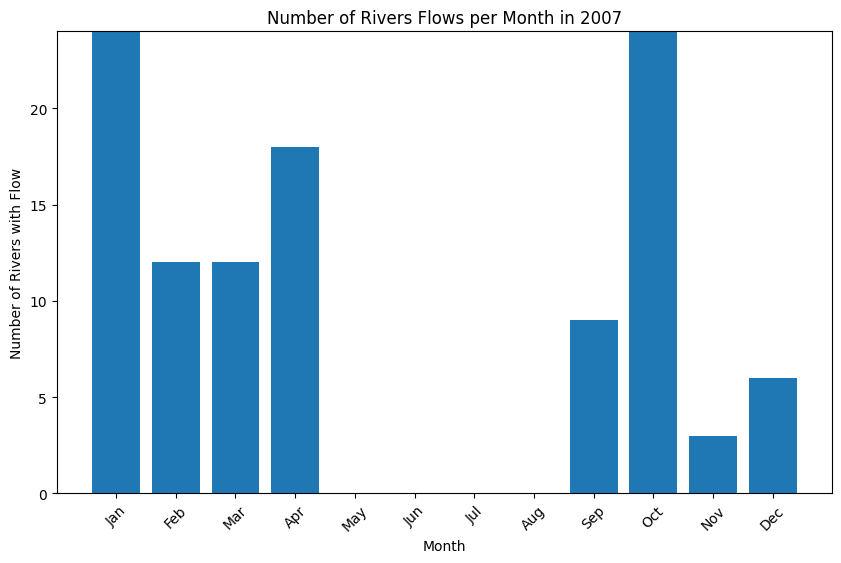

In [ ]:
plot_rivers_with_flow_by_month(flows, 2007)

In [ ]:
#Get data by API
stations = [('mizpe_ramon', 'MIZPE RAMON', {'latitude': 30.6125, 'longitude': 34.7967}),
('avdat', 'AVDAT', {'latitude': 30.8, 'longitude': 34.77}),
('sede_boker', 'SEDE BOQER', {'latitude': 30.871, 'longitude': 34.796}),
('arad', 'ARAD', {'latitude': 31.251, 'longitude': 35.186}),
('beer_sheva', 'BEER SHEVA', {'latitude': 31.333, 'longitude': 34.783})]

In [ ]:
df = pd.DataFrame(columns=['location', 'geometry'])

for station in stations:
  a,b,c = station
  location = a
  geo = (c['latitude'], c['longitude'])
  df = df.append({'location': location, 'geometry': geo}, ignore_index=True)

In [ ]:
df

,location,geometry
0,mizpe_ramon,"(30.6125, 34.7967)"
1,avdat,"(30.8, 34.77)"
2,sede_boker,"(30.871, 34.796)"
3,arad,"(31.251, 35.186)"
4,beer_sheva,"(31.333, 34.783)"


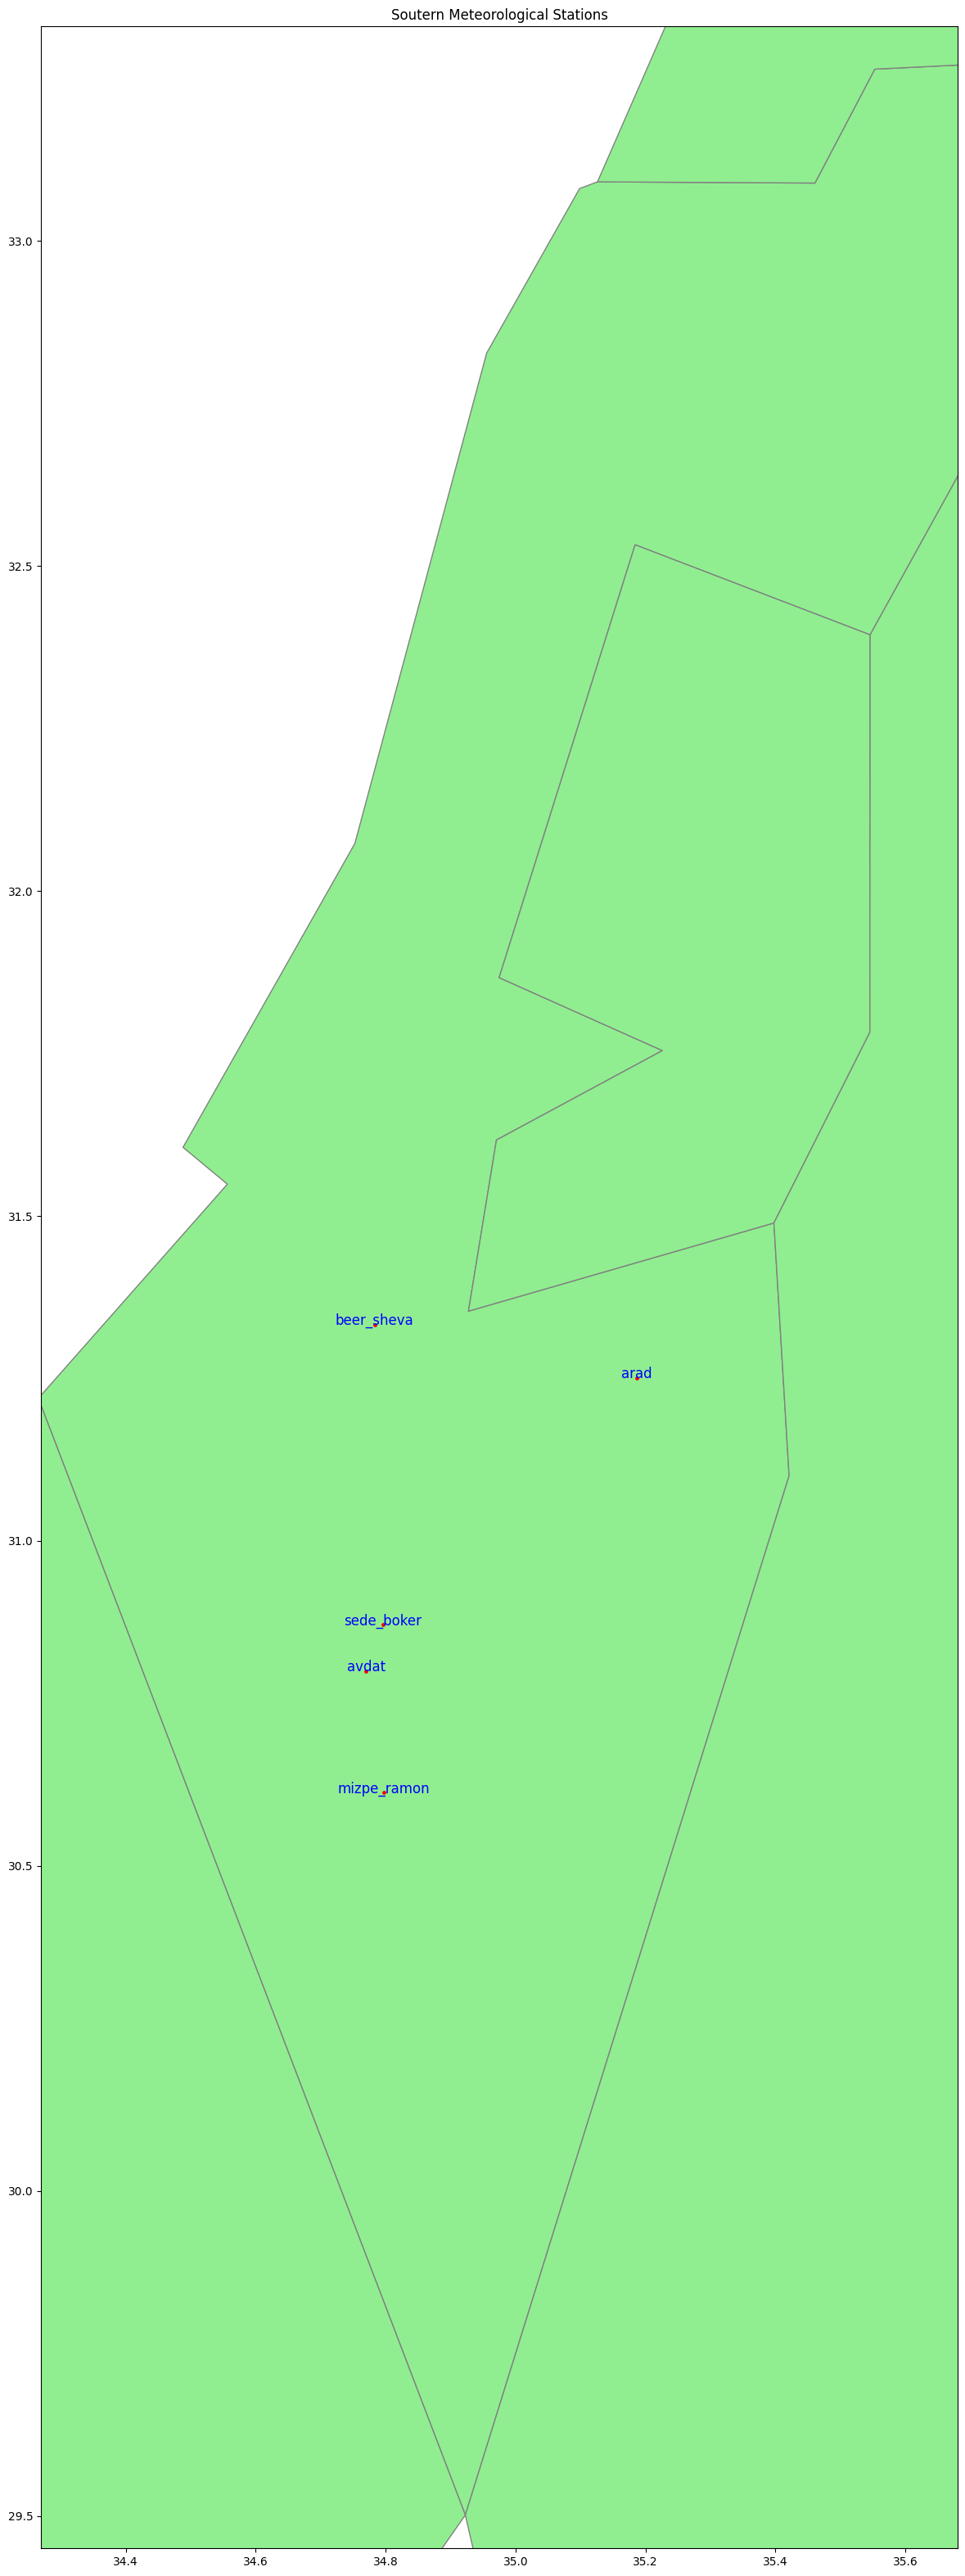

In [ ]:
def within_radius(point, existing_points, radius):
    for existing_point in existing_points:
        if point.distance(existing_point) <= radius:
            return True
    return False

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgreen', edgecolor='gray', figsize=(40, 40))

existing_points = []  # List to store existing points within thegiven radius
new_rows = []  # List to store rows that satisfy the condition

for idx, row in df.iterrows():
    pt = row['geometry']
    location = row['location']
    point = Point(pt[1], pt[0])

    if not within_radius(point, existing_points, 0.0005):
        new_rows.append(row)
        gdf = geopandas.GeoDataFrame({'location': [location], 'geometry': [point]})
        gdf.plot(ax=ax, marker='o', color='red', markersize=6)
        existing_points.append(point)  # Add the point to existing points list

        # Add label
        plt.annotate(text=location, xy=(pt[1], pt[0]), horizontalalignment='center', fontsize=12, color="blue")

# Create a new DataFrame with the collected rows
new_df = geopandas.GeoDataFrame(new_rows)


# Set the plot limits to zoom in on USA and Europe
ax.set_xlim(34.27, 35.68)  # Set x limits (longitude)
ax.set_ylim(29.45, 33.33)  # Set y limits (latitude)
ax.set_title("Soutern Meteorological Stations")
plt.show()
